![Coffee Lovers Unite!](coffee_lovers_pic.png)

In [217]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import us

# **Scrape the Location Counts for the United States**


In [218]:
# Listing coffee chain URLs and scraping locations and locations count
chains_urls = {
    "Starbucks": "https://www.menuism.com/restaurant-locations/starbucks-coffee-39564",
    "Dunkin’ Donuts": "https://www.menuism.com/restaurant-locations/dunkin-donuts-181624",
    "Peet’s Coffee & Tea": "https://www.menuism.com/restaurant-locations/peets-coffee-tea-84051",
    "Tim Horton’s": "https://www.menuism.com/restaurant-locations/tim-hortons-190025",
    "Panera Bread": "https://www.menuism.com/restaurant-locations/panera-bread-4258",
    "Caribou Coffee": "https://www.menuism.com/restaurant-locations/caribou-coffee-164861",
    "Au Bon Pain": "https://www.menuism.com/restaurant-locations/au-bon-pain-69342",
    "The Coffee Bean & Tea Leaf": "https://www.menuism.com/restaurant-locations/the-coffee-bean-tea-leaf-165988",
    "McDonald’s": "https://www.menuism.com/restaurant-locations/mcdonalds-21019"
}

# Storing results in a dictionary
chain_data = {}

for chain, url in chains_urls.items():
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extracting the data using the selector
    location_elements = soup.select('.list-unstyled-links a')

    # Extracting text from the elements
    locations_text = [elem.text for elem in location_elements]

    # Storing in the dictionary
    chain_data[chain] = locations_text

print(chain_data)

{'Starbucks': ['Alaska Starbucks Coffee locations (24)', 'Alabama Starbucks Coffee locations (73)', 'Arkansas Starbucks Coffee locations (33)', 'Arizona Starbucks Coffee locations (279)', 'California Starbucks Coffee locations (2362)', 'Colorado Starbucks Coffee locations (371)', 'Connecticut Starbucks Coffee locations (107)', 'District of Columbia Starbucks Coffee locations (72)', 'Delaware Starbucks Coffee locations (20)', 'Florida Starbucks Coffee locations (616)', 'Georgia Starbucks Coffee locations (248)', 'Hawaii Starbucks Coffee locations (72)', 'Iowa Starbucks Coffee locations (49)', 'Idaho Starbucks Coffee locations (57)', 'Illinois Starbucks Coffee locations (455)', 'Indiana Starbucks Coffee locations (193)', 'Kansas Starbucks Coffee locations (65)', 'Kentucky Starbucks Coffee locations (69)', 'Louisiana Starbucks Coffee locations (76)', 'Massachusetts Starbucks Coffee locations (208)', 'Maryland Starbucks Coffee locations (212)', 'Maine Starbucks Coffee locations (22)', 'Mic

In [219]:
# Making sure the 'us' library is installed
!pip install us

In [220]:
# Writing a function to get state abbreviations
def stateabb(state_name):
    state = us.states.lookup(state_name)
    if state:
        return state.abbr
    elif state_name == "District of Columbia": # the us library doesn't recognize District of Columbia
        return "DC"
    else:
        return None

# Creating empty list to store parsed data
rows = []
for chain, locations in chain_data.items():
    for location in locations:
        # Checking for special cases with punctuation
        if chain in ["McDonald’s", "Dunkin’ Donuts", "Peet’s Coffee & Tea", "Tim Horton’s"]:
            state_name = location.split(chain.split("’")[0])[0].strip()
        else:
            state_name = location.split(chain)[0].strip()

        # Extracting location count
        count_str = location.split('(')[-1].split(')')[0]
        if count_str.isdigit():
            count = int(count_str)
        else:
            continue

        # Getting state abbreviations
        abbreviation = stateabb(state_name)

        # Only adding rows with valid US state abbreviations
        if abbreviation:
            rows.append([state_name, chain, abbreviation, count])

# Creating a DataFrame
df = pd.DataFrame(rows, columns=['State', 'Coffee Chain', 'State Abbreviation', 'Location Count'])
print(df)

             State Coffee Chain State Abbreviation  Location Count
0           Alaska    Starbucks                 AK              24
1          Alabama    Starbucks                 AL              73
2         Arkansas    Starbucks                 AR              33
3          Arizona    Starbucks                 AZ             279
4       California    Starbucks                 CA            2362
..             ...          ...                ...             ...
264        Vermont   McDonald’s                 VT              30
265     Washington   McDonald’s                 WA             326
266      Wisconsin   McDonald’s                 WI             353
267  West Virginia   McDonald’s                 WV             107
268        Wyoming   McDonald’s                 WY              34

[269 rows x 4 columns]


In [6]:
# Sanity check
df.to_csv('/content/drive/My Drive/df.csv', index=False)

# **Supplemental Data**


In [222]:
# Extracting state names and populations from wiki
response = requests.get("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population")
soup = BeautifulSoup(response.content, 'html.parser')

# Extracting the table data except the header
table = soup.find_all('table')[0]
rows = table.find_all('tr')[1:]

state_population_data = {}
for row in rows:
    columns = row.find_all('td')
    if len(columns) < 4:
        continue
    state_name = columns[2].text.strip()
    population = int(columns[3].text.replace(',', ''))
    state_population_data[state_name] = population

# Converting state names to abbreviations
state_abbreviations = {}
for state, population in state_population_data.items():
    if state == "District of Columbia":
        abbreviation = "DC"
    else:
        state_obj = us.states.lookup(state)
        if state_obj:
            abbreviation = state_obj.abbr
        else: # finding locations with no abbreviation
            print(f"***No abbreviation for: {state}")
            continue
    state_abbreviations[abbreviation] = population

# Merging with the coffee dataframe
df['Population'] = df['State Abbreviation'].map(state_abbreviations)

print(df)

***No abbreviation for: U.S. Virgin Islands
***No abbreviation for: Contiguous United States
***No abbreviation for: The fifty states
***No abbreviation for: Fifty states + D.C.
***No abbreviation for: Total U.S. (including D.C. and territories)
             State Coffee Chain State Abbreviation  Location Count  Population
0           Alaska    Starbucks                 AK              24      733391
1          Alabama    Starbucks                 AL              73     5024279
2         Arkansas    Starbucks                 AR              33     3011524
3          Arizona    Starbucks                 AZ             279     7151502
4       California    Starbucks                 CA            2362    39538223
..             ...          ...                ...             ...         ...
264        Vermont   McDonald’s                 VT              30      643077
265     Washington   McDonald’s                 WA             326     7705281
266      Wisconsin   McDonald’s            

Create a region variable in your dataset according to the scheme on this wikipedia page: Northeast, Midwest, South, West. You do not need to scrape this information.



In [223]:
# Creating a dictionary to map regions to their respective states
region_to_states = {
    "Northeast": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"],
    "Midwest": ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin", "Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"],
    "South": ["Delaware", "District of Columbia", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "West Virginia", "Alabama", "Kentucky", "Mississippi", "Tennessee", "Arkansas", "Louisiana", "Oklahoma", "Texas"],
    "West": ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming", "Alaska", "California", "Hawaii", "Oregon", "Washington"]
}

# Creating a reverse mapping from state to region
states_to_region = {state: region for region, states in region_to_states.items() for state in states}

# Adding a new column to the dataframe for the region based on the state
df["Region"] = df["State"].map(states_to_region)

print(df)

             State Coffee Chain State Abbreviation  Location Count  \
0           Alaska    Starbucks                 AK              24   
1          Alabama    Starbucks                 AL              73   
2         Arkansas    Starbucks                 AR              33   
3          Arizona    Starbucks                 AZ             279   
4       California    Starbucks                 CA            2362   
..             ...          ...                ...             ...   
264        Vermont   McDonald’s                 VT              30   
265     Washington   McDonald’s                 WA             326   
266      Wisconsin   McDonald’s                 WI             353   
267  West Virginia   McDonald’s                 WV             107   
268        Wyoming   McDonald’s                 WY              34   

     Population     Region  
0        733391       West  
1       5024279      South  
2       3011524      South  
3       7151502       West  
4      3953822

In [224]:
# Checking for missing values in the "Region" column
missing_values = df["Region"].isnull().sum()

if missing_values > 0:
    print(f"There are {missing_values} missing values in the 'Region' column.")
    # Displaying rows with missing values
    print(df[df["Region"].isnull()])
else:
    print("There are no missing values in the 'Region' column.")

There are 1 missing values in the 'Region' column.
    State         Coffee Chain State Abbreviation  Location Count  Population  \
105    MA  Peet’s Coffee & Tea                 MA               7     7029917   

    Region  
105    NaN  


In [225]:
# ***Discovered that row 105 with Massachusetts Peet's Coffee & Tea had MA as the state name instead of Massachusetts
# Correcting the 'State' column for the entry with "Peet’s Coffee & Tea"
df.loc[(df['Coffee Chain'] == "Peet’s Coffee & Tea") & (df['State'] == "MA"), 'State'] = "Massachusetts"

# Updating the 'Region' column for the corrected entry
df.loc[df['State'] == "Massachusetts", 'Region'] = "Northeast"

print(df[df['State'] == "Massachusetts"])

             State         Coffee Chain State Abbreviation  Location Count  \
19   Massachusetts            Starbucks                 MA             208   
68   Massachusetts       Dunkin’ Donuts                 MA            1101   
105  Massachusetts  Peet’s Coffee & Tea                 MA               7   
110  Massachusetts         Tim Horton’s                 MA               5   
139  Massachusetts         Panera Bread                 MA              77   
195  Massachusetts          Au Bon Pain                 MA              67   
237  Massachusetts           McDonald’s                 MA             306   

     Population     Region  
19      7029917  Northeast  
68      7029917  Northeast  
105     7029917  Northeast  
110     7029917  Northeast  
139     7029917  Northeast  
195     7029917  Northeast  
237     7029917  Northeast  


Find the revenue, stock price, or your financial metric of choice for each of the companies listed above (if you can find a website to scrape these from that’s great!…but it’s okay if you manually enter these into R). Merge these values into your big dataset. Note: these values may be repeated for each state.



In [226]:
# Creating a dictionary with yearly revenue in billions for the 9 chains
revenue_data = {
    "Starbucks": 28.11,
    "Dunkin’ Donuts": 1.37,
    "Peet’s Coffee & Tea": 0.72,
    "Panera Bread": 2.93,
    "Caribou Coffee": 0.35,
    "Au Bon Pain": 0.282,  # YUM Brands, parent company
    "The Coffee Bean & Tea Leaf": 0.31,
    "McDonald’s": 100.21,
    "Tim Horton’s": 6.71
}

# Converting the dictionary to a dataframe
revenue_df = pd.DataFrame(list(revenue_data.items()), columns=['Coffee Chain', 'Tot. Rev (bill)'])

# Merging the revenue data with the main dataframe
merged_df = pd.merge(df, revenue_df, on='Coffee Chain', how='left')

# Calculating the total locations for each chain
total_locations = merged_df.groupby('Coffee Chain')['Location Count'].sum().reset_index()
total_locations.rename(columns={'Location Count': 'Total Chain Locations'}, inplace=True)

# Merging total locations with the df dataframe
merged_df = pd.merge(merged_df, total_locations, on='Coffee Chain', how='left')

# Calculating revenue generated by state for each chain
merged_df['State Rev (bill)'] = (merged_df['Tot. Rev (bill)'] / merged_df['Total Chain Locations']) * merged_df['Location Count']
merged_df['State Rev (bill)'] = merged_df['State Rev (bill)'].round(2)

# Dropping the 'Total Chain Locations' used for calculations
merged_df.drop(columns=['Total Chain Locations'], inplace=True)

print(merged_df[['State', 'Coffee Chain', 'Location Count', 'State Rev (bill)', 'Tot. Rev (bill)']])

             State Coffee Chain  Location Count  State Rev (bill)  \
0           Alaska    Starbucks              24              0.07   
1          Alabama    Starbucks              73              0.20   
2         Arkansas    Starbucks              33              0.09   
3          Arizona    Starbucks             279              0.76   
4       California    Starbucks            2362              6.45   
..             ...          ...             ...               ...   
264        Vermont   McDonald’s              30              0.18   
265     Washington   McDonald’s             326              1.95   
266      Wisconsin   McDonald’s             353              2.11   
267  West Virginia   McDonald’s             107              0.64   
268        Wyoming   McDonald’s              34              0.20   

     Tot. Rev (bill)  
0              28.11  
1              28.11  
2              28.11  
3              28.11  
4              28.11  
..               ...  
264       

In [227]:
# Sanity check
merged_df.head()

,State,Coffee Chain,State Abbreviation,Location Count,Population,Region,Tot. Rev (bill),State Rev (bill)
0,Alaska,Starbucks,AK,24,733391,West,28.11,0.07
1,Alabama,Starbucks,AL,73,5024279,South,28.11,0.20
2,Arkansas,Starbucks,AR,33,3011524,South,28.11,0.09
3,Arizona,Starbucks,AZ,279,7151502,West,28.11,0.76
4,California,Starbucks,CA,2362,39538223,West,28.11,6.45


# **Analyze**

Assess and comment on the prevalence of each chain. Some questions to consider (you don’t need to answer all of these and you may come up with your own):


*   Are some of these chains more prevalent in certain states than others? Possibly despite having less stores overall? Same questions for regions instead of states.

In [228]:
# Breaking down the prevalance by state
chains_state = merged_df.groupby(['Coffee Chain', 'State'])['Location Count'].sum().reset_index()
max_chains_state = chains_state.groupby('Coffee Chain').apply(lambda x: x.nlargest(1, 'Location Count')).reset_index(drop=True)
min_chains_state = chains_state.groupby('Coffee Chain').apply(lambda x: x.nsmallest(1, 'Location Count')).reset_index(drop=True)
print("States with the Most Chains:\n", max_chains_state)
print("\nStates with the Least Chains:\n", min_chains_state)

# Breaking down the prevalance by region
chains_region = merged_df.groupby(['Coffee Chain', 'Region'])['Location Count'].sum().reset_index()
print("\nChains by Region:\n", chains_region.pivot(index='Coffee Chain', columns='Region', values='Location Count'))

# Overall counts of all the chains
chains_total = merged_df.groupby('Coffee Chain')['Location Count'].sum().sort_values(ascending=False)
print("\nOverall counts of all the chains:\n", chains_total)

States with the Most Chains:
                  Coffee Chain          State  Location Count
0                 Au Bon Pain  Massachusetts              67
1              Caribou Coffee      Minnesota             312
2              Dunkin’ Donuts  Massachusetts            1101
3                  McDonald’s     California            1623
4                Panera Bread        Florida             227
5         Peet’s Coffee & Tea     California             163
6                   Starbucks     California            2362
7  The Coffee Bean & Tea Leaf     California             175
8                Tim Horton’s       Michigan             191

States with the Least Chains:
                  Coffee Chain         State  Location Count
0                 Au Bon Pain      Kentucky               1
1              Caribou Coffee       Indiana               1
2              Dunkin’ Donuts       Alabama               1
3                  McDonald’s  North Dakota              29
4                Panera Brea

Amongst all the states and DC, California has the most amount of locations for McDonald's, Peet's, Starbucks, and Coffee Bean & Tea Leaf. Massachusetts has the most Au Bon Pain and Dunkin' Donuts locations. As far as overall, McDonald's and Starbucks have the most stores, and Dunkin' Donuts is in 3rd, so not despite having the least amount of stores for these chains. Howeer, Peet's and Coffee Bean & Tea Leaf are the least and 2nd least overall stores and they are prevalent in California.

McDonald's and Starbucks are prevalent across all 4 regions with Dunkin' Donuts 3rd, similar to the states breakdown. They all have the most stores in as well. The Coffee Bean & Tea Leaf are have 239 stores in the West region, and 9 in the South, but are not present in the Midwest and Northeast. Peet's Coffee is also almost non-existent in other regions besides the West. There is nothing that surprises me or out of the ordinary from the breakdown of the regions.

*   How does your chosen financial metric change by state and region for each chain? For example, having 5 stores in California is very different from having 5 stores in Wyoming.

In [229]:
# Creating an empty dictionary to store the results
chain_state_rev_loc = {}

# Extracting each state's revenue and number of locations, then storing it
for chain in merged_df['Coffee Chain'].unique():
    chain_data = merged_df[merged_df['Coffee Chain'] == chain][['State', 'Location Count', 'State Rev (bill)']]
    chain_state_rev_loc[chain] = chain_data

# Using a loop to print the Financial Metric by State for each chain, along with location count
for chain, state_chain_df in chain_state_rev_loc.items():
    print(f"\nFinancial Metric by State for {chain}:")
    print(state_chain_df)


Financial Metric by State for Starbucks:
                   State  Location Count  State Rev (bill)
0                 Alaska              24              0.07
1                Alabama              73              0.20
2               Arkansas              33              0.09
3                Arizona             279              0.76
4             California            2362              6.45
5               Colorado             371              1.01
6            Connecticut             107              0.29
7   District of Columbia              72              0.20
8               Delaware              20              0.05
9                Florida             616              1.68
10               Georgia             248              0.68
11                Hawaii              72              0.20
12                  Iowa              49              0.13
13                 Idaho              57              0.16
14              Illinois             455              1.24
15            

There is a direct positive correlation with location count within a state and chain revenue. The more locations correlates strongly to more revenue, so yes, 5 locations in California is very different from 5 locations in Wyoming.

In [230]:
# Grouping by 'Coffee Chain' and 'Region', and summing the states in each region to get total revenue and location count for each chain in each region
revenue_region = merged_df.groupby(['Coffee Chain', 'Region']).agg({'State Rev (bill)': 'sum', 'Location Count': 'sum'}).reset_index()

# Rename the 'State Revenue (bill)' column to 'Region Rev (bill)'
revenue_region = revenue_region.rename(columns={'State Rev (bill)': 'Region Rev (bill)'})

print("\nRevenue by Region:")
print(revenue_region)


Revenue by Region:
                  Coffee Chain     Region  Region Rev (bill)  Location Count
0                  Au Bon Pain    Midwest               0.06              64
1                  Au Bon Pain  Northeast               0.17             184
2                  Au Bon Pain      South               0.07              83
3                  Au Bon Pain       West               0.00               1
4               Caribou Coffee    Midwest               0.30             520
5               Caribou Coffee  Northeast               0.00               6
6               Caribou Coffee      South               0.04              87
7               Caribou Coffee       West               0.01              10
8               Dunkin’ Donuts    Midwest               0.18             929
9               Dunkin’ Donuts  Northeast               0.82            3871
10              Dunkin’ Donuts      South               0.30            1512
11              Dunkin’ Donuts       West               

It's the same for regional revenue, the more locations is strongly positively correlated to more revenue. If we take Coffee Bean & Tea Leaf for example, most of their locations are in the West region, and there is a huge difference between the West region's revenue when compared to the South region.


*   Does the distribution of each chain’s stores match population distribution, by both state/region?


In [231]:
# Calculating store distribution for each state and region
merged_df['Store Density'] = merged_df['Location Count'] / merged_df['Population']

# Creating a dataframe for states
state_df = merged_df[['State', 'Coffee Chain', 'Population', 'Location Count', 'Store Density', 'Region']].copy()
state_df['Type'] = 'State'

# Creating a dataframe for regions
region_df = merged_df.groupby(['Region', 'Coffee Chain']).agg({
    'Population': 'sum',
    'Location Count': 'sum'
}).reset_index()
region_df['Store Density'] = region_df['Location Count'] / region_df['Population']
region_df['Type'] = 'Region'
region_df['State'] = None  # Added an empty 'State' column to match the structure of state_df

# Combining the state and region dataframes
combined_df = pd.concat([state_df, region_df], ignore_index=True)

In [232]:
# Sanity check
combined_df

,State,Coffee Chain,Population,Location Count,Store Density,Region,Type
0,Alaska,Starbucks,733391,24,0.000033,West,State
1,Alabama,Starbucks,5024279,73,0.000015,South,State
2,Arkansas,Starbucks,3011524,33,0.000011,South,State
3,Arizona,Starbucks,7151502,279,0.000039,West,State
4,California,Starbucks,39538223,2362,0.000060,West,State
...,...,...,...,...,...,...,...
297,None,McDonald’s,78588572,3411,0.000043,West,Region
298,None,Panera Bread,71467218,323,0.000005,West,Region
299,None,Peet’s Coffee & Tea,61814359,190,0.000003,West,Region
300,None,Starbucks,78588572,4414,0.000056,West,Region


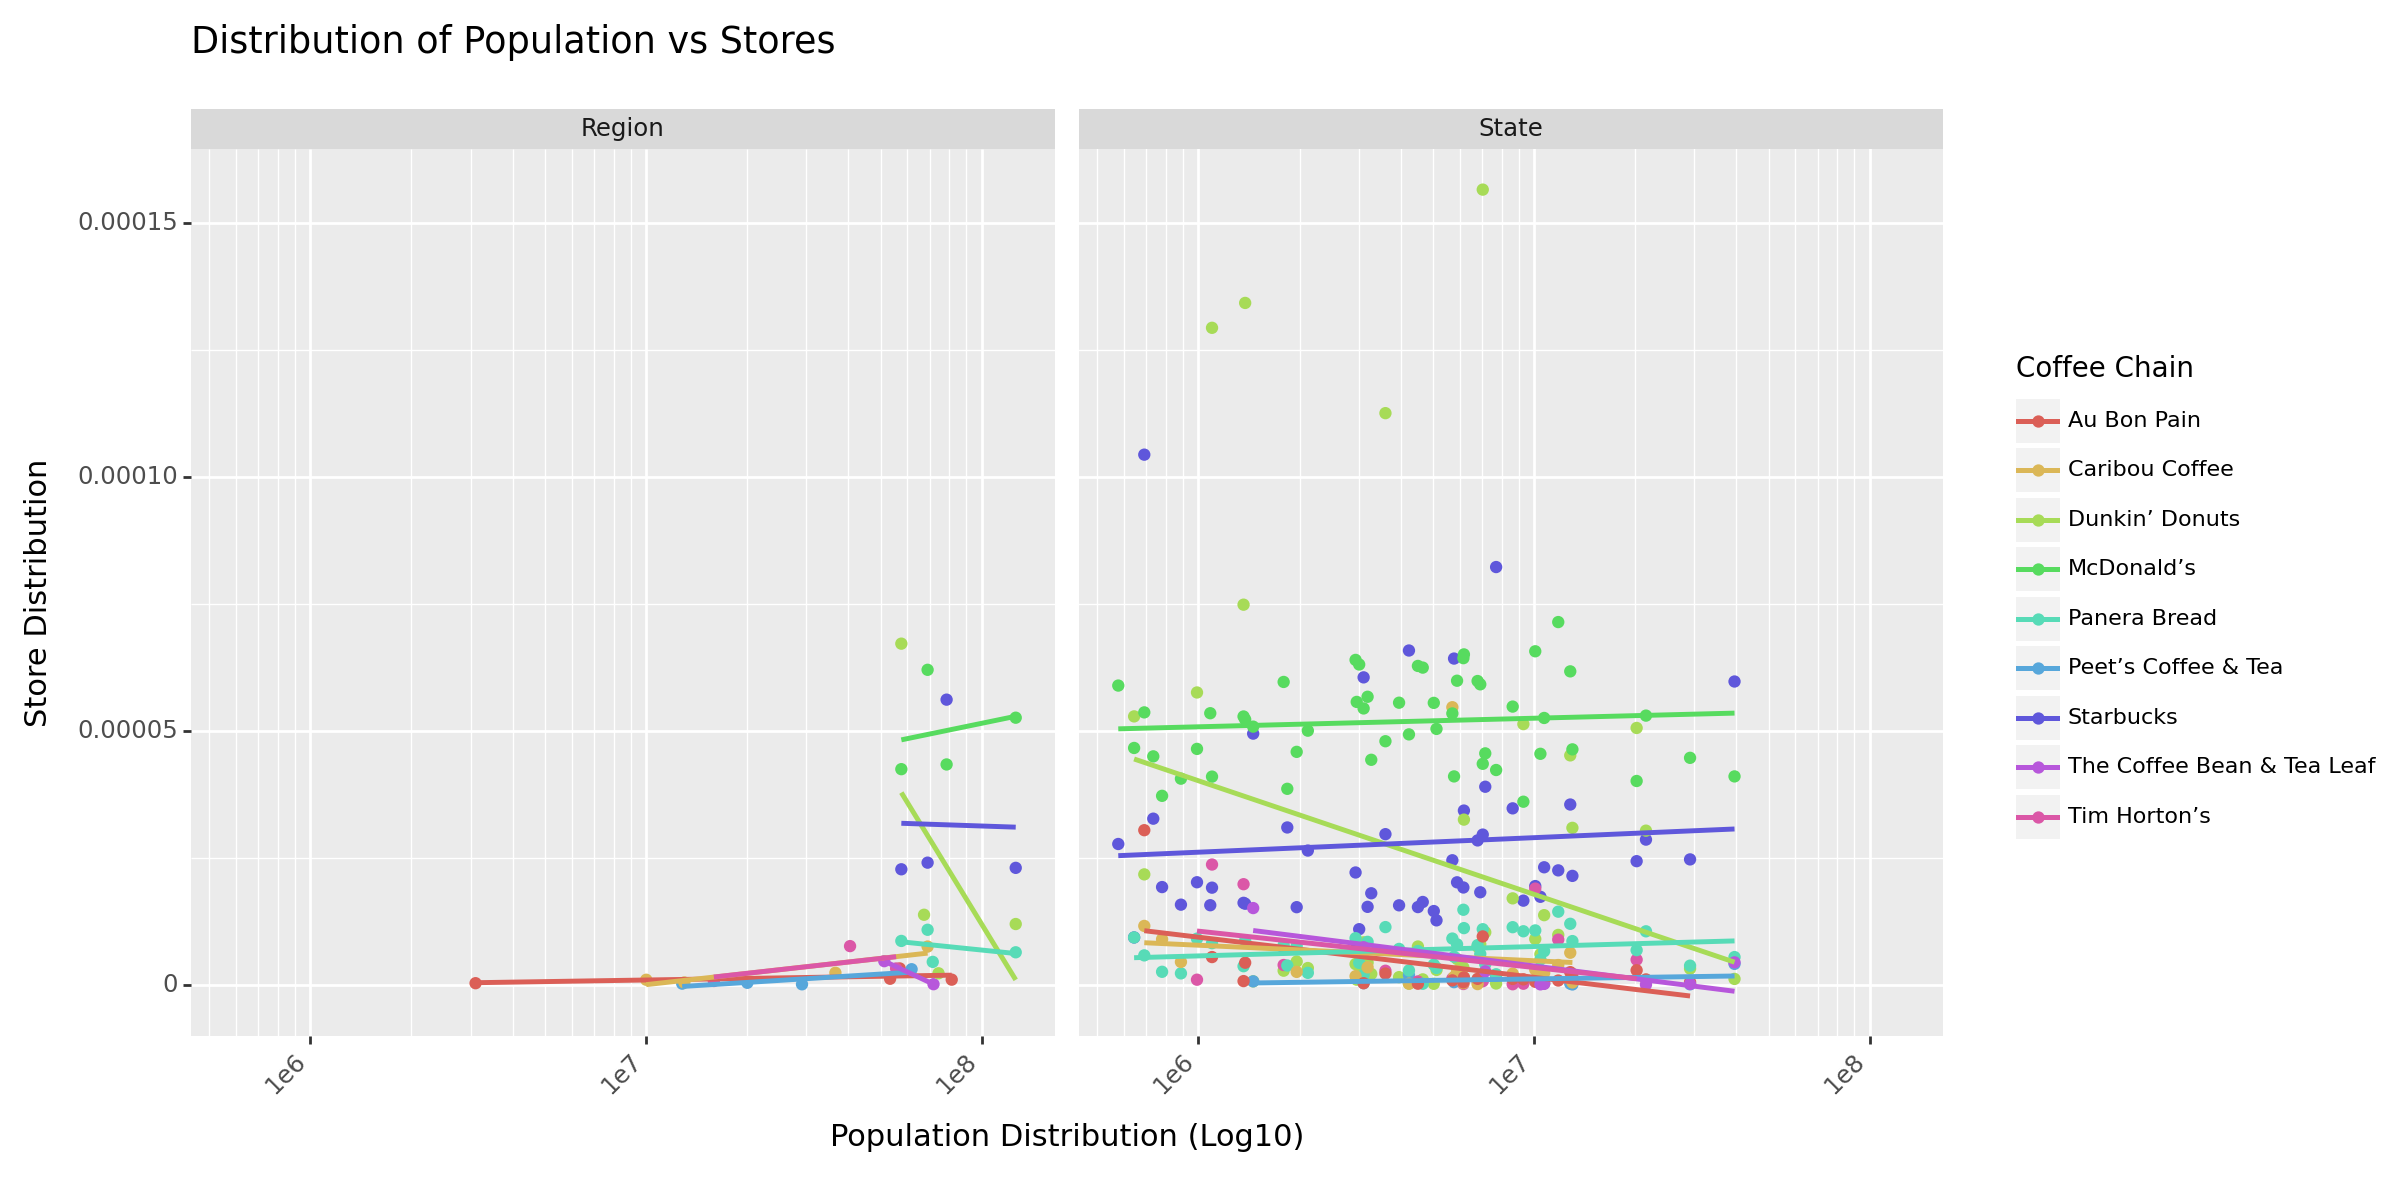

In [233]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme, element_text, scale_x_log10

# Plotting population distribution against chain distribution, by state and region
plot = (
    ggplot(combined_df, aes(x='Population', y='Store Density', color='Coffee Chain')) +
    geom_point() +
    geom_smooth(method='lm', se=False) +
    facet_wrap('~ Type', ncol=2) +
    labs(title='Distribution of Population vs Stores',
         x='Population Distribution (Log10)',
         y='Store Distribution') +
    scale_x_log10() +
    theme(figure_size=(12, 6),
          legend_title=element_text(size=10),
          legend_text=element_text(size=8),
          axis_text_x=element_text(rotation=45, hjust=1))
)
print(plot)

Taking a look at the Region distributions, The Coffee Bean & Tea Leaf, Panera Bread, and Dunkin' Donuts and even Starbucks, all have negative slopes. The other stores have weak positive or neutral correlation, which indicates that store distributions did not necessarily follow population distribution in the US. Looking at the State distributions, it's interesting to see that McDonald's stores are mostly around the regression line, while Starbucks stores are a bit distanced. Similar to the Region distributions, the State breakdown shows that population did not necessarily influence chain locations, where in fact, there was more negative correlation than positive or neutral.


*   Do the financial data match what you’d expect based on the number and locations of the stores? Why or why not?



In [234]:
import numpy as np

# Finding the correlation between each chain's state revenue and number of locations
correlations = merged_df.groupby('Coffee Chain').apply(lambda x: np.corrcoef(x['Location Count'], x['State Rev (bill)'])[0, 1])
print("Correlation between revenue and number of stores for each chain:")
print(correlations)

# Finding the average revenue per store for each chain in each region
region_avg_rev = merged_df.groupby(['Coffee Chain', 'Region']).apply(lambda x: x['State Rev (bill)'].sum() / x['Location Count'].sum()).reset_index()
region_avg_rev.columns = ['Coffee Chain', 'Region', 'Avg Rev']
print("\nAverage revenue per store for each chain in each region:")
print(region_avg_rev)

Correlation between revenue and number of stores for each chain:
Coffee Chain
Au Bon Pain                   0.983110
Caribou Coffee                0.996724
Dunkin’ Donuts                0.999040
McDonald’s                    0.999999
Panera Bread                  0.999057
Peet’s Coffee & Tea           0.999936
Starbucks                     0.999996
The Coffee Bean & Tea Leaf    0.999425
Tim Horton’s                  0.999993
dtype: float64

Average revenue per store for each chain in each region:
                  Coffee Chain     Region   Avg Rev
0                  Au Bon Pain    Midwest  0.000938
1                  Au Bon Pain  Northeast  0.000924
2                  Au Bon Pain      South  0.000843
3                  Au Bon Pain       West  0.000000
4               Caribou Coffee    Midwest  0.000577
5               Caribou Coffee  Northeast  0.000000
6               Caribou Coffee      South  0.000460
7               Caribou Coffee       West  0.001000
8               Dunkin’ Donuts

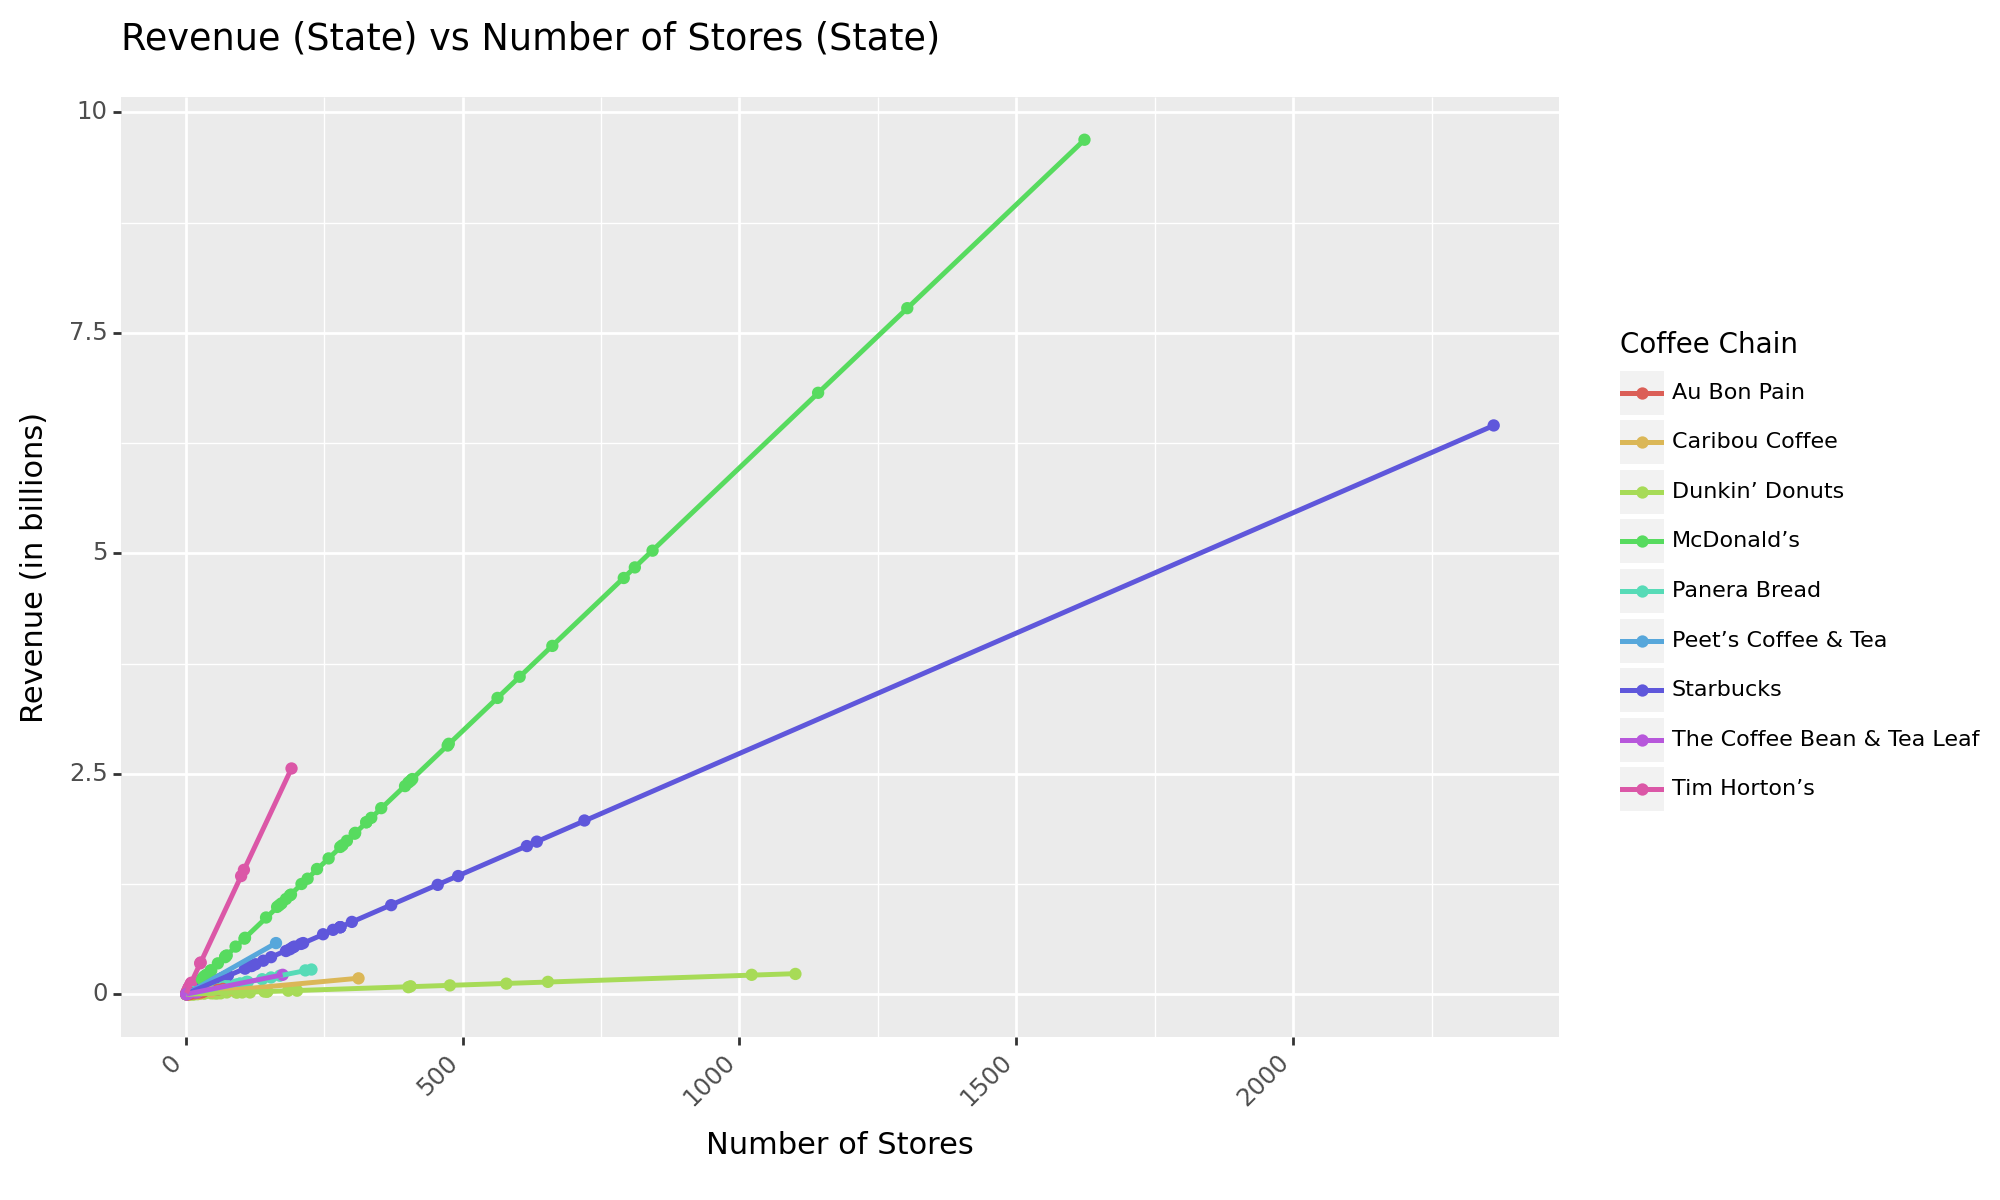

In [235]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme, element_text

plot = (
    ggplot(merged_df, aes(x='Location Count', y='State Rev (bill)', color='Coffee Chain')) +
    geom_point() +
    geom_smooth(method='lm', se=False) +
    labs(title='Revenue (State) vs Number of Stores (State)',
         x='Number of Stores',
         y='Revenue (in billions)') +
    theme(figure_size=(10, 6),
          legend_title=element_text(size=10),
          legend_text=element_text(size=8),
          axis_text_x=element_text(rotation=45, hjust=1))
)
print(plot)

There is a strong positive correlation between number of stores and revenue in the US in terms of Tim Horton's, McDonald's, and Starbucks. In fact, all stores have positive correlation with revenue, which was expected. This list of 9 coffee chains being analyzed are not all solely selling coffee though; notably McDonald's, Au Bon Pain, and Panera Bread.

# **Automate**

Convert your code for Exercises 1-3 above to a function that takes a single argument: the menuism URL. This function should

*    Scrape the information on state names and corresponding number of store locations on the webpage specified

*    Extract the name of the company from either the URL specified or the webpage

*    Return a clean, organized dataset that has three columns: state abbreviation, location count, company name. Company name will likely be repeated on every row.

In [236]:
# Making sure the 'us' library is installed
!pip install us

In [237]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import us

def stateabb(state_name):
    state = us.states.lookup(state_name)
    if state:
        return state.abbr
    elif state_name == "District of Columbia": # the us library doesn't recognize District of Columbia
        return "DC"
    else:
        return None

def scrape_menuism(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    location_elements = soup.select('.list-unstyled-links a')
    locations_text = [elem.text for elem in location_elements]

    # Extracting company name from the h3 tag containing the word "Locations" ***Some pages had more than one h3 heading***
    h3_tags = soup.find_all('h3')
    company_name = None
    for tag in h3_tags:
        if "Locations" in tag.text:
            match = re.search(r'(\d+)\s+(.+?)\s+Locations', tag.text)
            if match:
                company_name = match.group(2).strip()
                break

    if not company_name:
        # Fallback to the previous method if the regex doesn't match
        company_name = " ".join(h3_tags[0].text.split()[1:-1])

    # Extracting state names and counts using regular expressions
    rows = []
    unmatched_locations = []
    for location in locations_text:
        match = re.search(r'([\w\s’]+?)\s+' + re.escape(company_name) + r'\s+locations\s+\((\d+)\)', location, re.IGNORECASE)
        if not match:
            # Try a more general regex pattern
            match = re.search(r'([\w\s’]+?)\s+locations\s+\((\d+)\)', location, re.IGNORECASE)
        if match:
            state_name = match.group(1).strip()
            count = int(match.group(2))
            abbreviation = stateabb(state_name)
            if abbreviation:
                rows.append([abbreviation, count, company_name])
            else:
                unmatched_locations.append(location)
        else:
            unmatched_locations.append(location)

    # Converting to a dataframe
    df = pd.DataFrame(rows, columns=['State Abbreviation', 'Location Count', 'Company Name'])

    return df

In [238]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/starbucks-coffee-39564"
df = scrape_menuism(url)
print(df)

   State Abbreviation  Location Count      Company Name
0                  AK              24  Starbucks Coffee
1                  AL              73  Starbucks Coffee
2                  AR              33  Starbucks Coffee
3                  AZ             279  Starbucks Coffee
4                  CA            2362  Starbucks Coffee
5                  CO             371  Starbucks Coffee
6                  CT             107  Starbucks Coffee
7                  DC              72  Starbucks Coffee
8                  DE              20  Starbucks Coffee
9                  FL             616  Starbucks Coffee
10                 GA             248  Starbucks Coffee
11                 HI              72  Starbucks Coffee
12                 IA              49  Starbucks Coffee
13                 ID              57  Starbucks Coffee
14                 IL             455  Starbucks Coffee
15                 IN             193  Starbucks Coffee
16                 KS              65  Starbucks

In [239]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/dunkin-donuts-181624"
df = scrape_menuism(url)
print(df)

   State Abbreviation  Location Count    Company Name
0                  AL               1  Dunkin' Donuts
1                  AR              11  Dunkin' Donuts
2                  AZ              74  Dunkin' Donuts
3                  CA              46  Dunkin' Donuts
4                  CO               5  Dunkin' Donuts
5                  CT             406  Dunkin' Donuts
6                  DC              15  Dunkin' Donuts
7                  DE              57  Dunkin' Donuts
8                  FL             654  Dunkin' Donuts
9                  GA             147  Dunkin' Donuts
10                 HI               1  Dunkin' Donuts
11                 IA              14  Dunkin' Donuts
12                 IL             579  Dunkin' Donuts
13                 IN              51  Dunkin' Donuts
14                 KS              12  Dunkin' Donuts
15                 KY              34  Dunkin' Donuts
16                 LA               5  Dunkin' Donuts
17                 MA       

In [240]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/peets-coffee-tea-84051"
df = scrape_menuism(url)
print(df)

  State Abbreviation  Location Count         Company Name
0                 CA             163  Peet's Coffee & Tea
1                 CO               3  Peet's Coffee & Tea
2                 HI               1  Peet's Coffee & Tea
3                 IL               3  Peet's Coffee & Tea
4                 NV               1  Peet's Coffee & Tea
5                 OR               8  Peet's Coffee & Tea
6                 PA               1  Peet's Coffee & Tea
7                 TX               3  Peet's Coffee & Tea
8                 WA              14  Peet's Coffee & Tea
9                 MA               7  Peet's Coffee & Tea


In [241]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/tim-hortons-190025"
df = scrape_menuism(url)
print(df)

   State Abbreviation  Location Count Company Name
0                  CT              10  Tim Hortons
1                  DE               1  Tim Hortons
2                  IN               5  Tim Hortons
3                  KY               3  Tim Hortons
4                  MA               5  Tim Hortons
5                  ME              27  Tim Hortons
6                  MI             191  Tim Hortons
7                  MN               7  Tim Hortons
8                  MO               1  Tim Hortons
9                  NJ               2  Tim Hortons
10                 NY             100  Tim Hortons
11                 OH             105  Tim Hortons
12                 PA               9  Tim Hortons
13                 RI              26  Tim Hortons
14                 VA               1  Tim Hortons
15                 WV               7  Tim Hortons


In [242]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/panera-bread-4258"
df = scrape_menuism(url)
print(df)

   State Abbreviation  Location Count  Company Name
0                  AL              20  Panera Bread
1                  AR              13  Panera Bread
2                  AZ              29  Panera Bread
3                  CA             216  Panera Bread
4                  CO              32  Panera Bread
5                  CT              41  Panera Bread
6                  DC               4  Panera Bread
7                  DE               9  Panera Bread
8                  FL             227  Panera Bread
9                  GA              71  Panera Bread
10                 IA              27  Panera Bread
11                 ID               7  Panera Bread
12                 IL             154  Panera Bread
13                 IN              53  Panera Bread
14                 KS              27  Panera Bread
15                 KY              30  Panera Bread
16                 LA               1  Panera Bread
17                 MA              77  Panera Bread
18          

In [243]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/caribou-coffee-164861"
df = scrape_menuism(url)
print(df)

   State Abbreviation  Location Count    Company Name
0                  CO               9  Caribou Coffee
1                  DC               8  Caribou Coffee
2                  GA              25  Caribou Coffee
3                  IA              11  Caribou Coffee
4                  IL              81  Caribou Coffee
5                  IN               1  Caribou Coffee
6                  KS               5  Caribou Coffee
7                  MD               9  Caribou Coffee
8                  MI              30  Caribou Coffee
9                  MN             312  Caribou Coffee
10                 MO               2  Caribou Coffee
11                 NC              26  Caribou Coffee
12                 ND               7  Caribou Coffee
13                 NE               5  Caribou Coffee
14                 OH              46  Caribou Coffee
15                 OR               1  Caribou Coffee
16                 PA               6  Caribou Coffee
17                 SD       

In [244]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/au-bon-pain-69342"
df = scrape_menuism(url)
print(df)

   State Abbreviation  Location Count Company Name
0                  CT               8  Au Bon Pain
1                  DC              21  Au Bon Pain
2                  FL              23  Au Bon Pain
3                  GA               3  Au Bon Pain
4                  IL              32  Au Bon Pain
5                  IN               8  Au Bon Pain
6                  KY               1  Au Bon Pain
7                  MA              67  Au Bon Pain
8                  MD               9  Au Bon Pain
9                  ME               1  Au Bon Pain
10                 MI               6  Au Bon Pain
11                 MN               5  Au Bon Pain
12                 MO               3  Au Bon Pain
13                 NH               6  Au Bon Pain
14                 NJ              10  Au Bon Pain
15                 NV               1  Au Bon Pain
16                 NY              58  Au Bon Pain
17                 OH              10  Au Bon Pain
18                 PA          

In [245]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/the-coffee-bean-tea-leaf-165988"
df = scrape_menuism(url)
print(df)

  State Abbreviation  Location Count                Company Name
0                 AZ              19  The Coffee Bean & Tea Leaf
1                 CA             175  The Coffee Bean & Tea Leaf
2                 FL               1  The Coffee Bean & Tea Leaf
3                 GA               2  The Coffee Bean & Tea Leaf
4                 HI              22  The Coffee Bean & Tea Leaf
5                 NC               1  The Coffee Bean & Tea Leaf
6                 NV              23  The Coffee Bean & Tea Leaf
7                 TX               5  The Coffee Bean & Tea Leaf


In [246]:
# Change the url to desired coffee chain
url = "https://www.menuism.com/restaurant-locations/mcdonalds-21019"
df = scrape_menuism(url)
print(df)

   State Abbreviation  Location Count Company Name
0                  AK              33   McDonald's
1                  AL             279   McDonald's
2                  AR             190   McDonald's
3                  AZ             326   McDonald's
4                  CA            1623   McDonald's
5                  CO             237   McDonald's
6                  CT             173   McDonald's
7                  DC              37   McDonald's
8                  DE              46   McDonald's
9                  FL            1142   McDonald's
10                 GA             563   McDonald's
11                 HI              74   McDonald's
12                 IA             181   McDonald's
13                 ID              71   McDonald's
14                 IL             791   McDonald's
15                 IN             406   McDonald's
16                 KS             188   McDonald's
17                 KY             283   McDonald's
18                 LA          